In [1]:
##import modules
import cv2
import numpy as np
import pandas as pd
import NaiveDE

##neural net
import torch
import torch.nn.functional as F

import umap
import scipy.stats
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score

from bi_tempered_loss_pytorch import bi_tempered_logistic_loss

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
##1. Define Convolutional neural net of CoSTA, for Slide-seq data
##
class ConvNet(torch.nn.Module):
    def __init__(self,out_dim=25):
        super(ConvNet, self).__init__()
        self.out_dim = out_dim
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 128, kernel_size=5,stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=5,stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=5,stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.Tanh(),#torch.nn.ReLU(),#
            torch.nn.MaxPool2d(kernel_size=2))
        self.dropout = torch.nn.Dropout()
        self.fc2 = torch.nn.Linear(128, self.out_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, 128)
        out = F.normalize(out.view(-1, 128), p=2, dim=1)
        out = self.fc2(out)
        return out
    
    def forward_feature(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1, 128)
        out = F.normalize(out.view(-1, 128), p=2, dim=1)
        return out

def weights_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
        

In [3]:
##evalution is the essential function in CoSTA. It performs clustering and generates soft assignment
##
def evaluation(y_pred,cluster_method="Kmeans",num_cluster = 25,n_neighbors=20,min_dist=0.0):
    '''
    it supports Kmeans, Spectral clustering and GMM 3 clustering methods
    '''
    if cluster_method=="Kmeans":
        embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=num_cluster,
                              metric="euclidean").fit_transform(y_pred)
    
        kmeans = KMeans(n_clusters=num_cluster, random_state=1).fit(embedding)
        centroid = kmeans.cluster_centers_.copy()
        y_label = kmeans.labels_.copy()
        y_pseudo=np.zeros((y_pred.shape[0],num_cluster))
    elif cluster_method=="SC":
        embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=num_cluster,
                              metric="euclidean").fit_transform(y_pred)
        clustering = SpectralClustering(n_clusters=num_cluster,
                                        assign_labels="discretize",
                                        random_state=0).fit(embedding)
        y_label = clustering.labels_.copy()
        centroid = pd.DataFrame(embedding.copy())
        centroid['label']=y_label
        centroid = centroid.groupby('label').mean().values
        y_pseudo=np.zeros((y_pred.shape[0],num_cluster))

    else:
        embedding = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=num_cluster,
                              metric="euclidean").fit_transform(y_pred)
        gmm = GaussianMixture(n_components=num_cluster).fit(embedding)
        y_label = gmm.predict(embedding)
        centroid = pd.DataFrame(embedding.copy())
        centroid['label']=y_label
        centroid = centroid.groupby('label').mean().values

        y_pseudo=np.zeros((y_pred.shape[0],num_cluster))
    
    ##alternative approach to assigne soft-assignment through t-student distribution
    ##t-student distribution kernel soft-assignment,alpha=1
    #for j in range(centroid.shape[0]):
    #    y_pseudo[:,j]=(np.linalg.norm(embedding-centroid[j,:],axis=1)+1)**(-1)
        ##cosine distance
        #y_pseudo[:,j]=((1-cosine_similarity(embedding,centroid[j,:].reshape(1,embedding.shape[1]))+1)**(-1))[:,0]
    #y_pseudo = pd.DataFrame(y_pseudo)
    #y_pseudo2=np.zeros((y_pred.shape[0],centroid.shape[0]))
    #for j in range(centroid.shape[0]):
    #    y_pseudo2[:,j]=y_pseudo.iloc[:,j].values/np.sum(
    #        y_pseudo[y_pseudo.columns.difference([j])].values,axis=1)
    #y_pseudo = y_pseudo2
    
    ##soft-assignment used in this study
    ##distance based soft-assignment
    for j in range(centroid.shape[0]):
        ##euclidean distance
        y_pseudo[:,j]=1/np.linalg.norm(embedding-centroid[j,:],axis=1)
        ##cosine similarity
        #y_pseudo[:,j]=1/(1-cosine_similarity(embedding,centroid[j,:].reshape(1,embedding.shape[1])))[:,0]
    y_pseudo=softmax(y_pseudo,axis=1)
    
    ##auxiliary target distribution
    f = np.sum(np.square(y_pseudo)/np.sum(y_pseudo,axis=0),axis=1)
    y2 = np.square(y_pseudo)/np.sum(y_pseudo,axis=0)
    au_tar = (y2.T/f).T
    
    return au_tar, y_label,embedding
        
##Use representation learned by CoSTA to find neighbors of genes of interest
##
def get_neighors(gene_list=None, embedding=None, target=["Vim"]):
    embedding = pd.DataFrame(embedding)
    embedding.index = gene_list
    gene_neighbors={}
    for i in target:
        distance = np.linalg.norm(embedding.values-embedding.loc[i,:].values,axis=1)
        distance = pd.DataFrame(distance)
        distance.index=gene_list
        distance = distance.sort_values(ascending=True,by=0)
        gene_neighbors[i]=distance.index.tolist()[1:51]
    return gene_neighbors


In [11]:
##2. load Slide-seq data
##
gene = pd.read_csv("spatial_gene_profile_slide_seq_2w_raw.csv",
                    header=0,index_col=0)
#gene = pd.read_csv("spatial_gene_profile_slide_seq_3d_raw.csv",
#                    header=0,index_col=0)
    
n,m = gene.shape
a,b = gene['x'].values[1],gene['y'].values[1]
ori_X = gene.iloc[:,:-2].values


In [12]:
##3. reshape matrix into 48X48
##
ori_X = ori_X.reshape((n,a,b))
resize_X = []
for i in range(n):
    resize_X.append(cv2.resize(ori_X[i,:,:], (48,48)))
    
ori_X = np.asarray(resize_X)
new_X=ori_X.copy()
new_X = new_X.reshape((n,1,48,48))
del resize_X,a,b,i


In [6]:
##4. preprocess and normalization through NaiveDE
##
n,_,a,b=new_X.shape
counts = pd.DataFrame(new_X.reshape(n,a*b)).T
counts.columns = gene.index

totals = np.sum(counts,axis=1)
bin1 = np.repeat(np.array([i for i in range(a)]), b)
bin2 = np.tile(np.array([i for i in range(b)]), a)
samples = pd.DataFrame({'x':bin1,'y':bin2,'total_counts':totals})

resid_expr = NaiveDE.regress_out(samples, counts.T, 'np.log(total_counts+1)').T
new_X = resid_expr.T.values.reshape((n,1,48,48))


In [7]:
##5. Training CoSTA for 5 times, and get 5 representations
##
output_dim = 30##training with 30 clusters
num_epoch = 11##training for 10 epochs
batch_size = 128
t1, t2 = 0.8, 1.2## parameters for bi-tempered logistic loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = []##store learned respresentation

for i in range(1,6):
    net = ConvNet(out_dim=output_dim)
    net.apply(weights_init)
    
    
    X_all_tensor = torch.tensor(new_X).float()
    y_pred = net.forward_feature(X_all_tensor)
    y_pred = torch.Tensor.cpu(y_pred).detach().numpy()
    au_tar, y_label, embedding = evaluation(y_pred,n_neighbors=20,
                                            min_dist=0.0,num_cluster=output_dim,
                                            cluster_method="GMM")##get the initial soft assignment

    opt = torch.optim.SGD(net.parameters(),lr=0.01, momentum=0.9)##learning plan

    for k in range(1,num_epoch):
        old_label=y_label.copy()
        net.to(device)
        
        X_train, X_test, y_train, y_test = train_test_split(new_X, au_tar, test_size=0.3)
        X_tensor=torch.tensor(X_train).float()
        y_tensor = torch.tensor(y_train).float()
        n = y_train.shape[0]
        for j in range(n//batch_size):
            inputs = X_tensor[j*batch_size:(j+1)*batch_size,:,:,:].to(device)
            outputs = y_tensor[j*batch_size:(j+1)*batch_size,:].to(device)
            opt.zero_grad()
            output = net.forward(inputs)
            loss = bi_tempered_logistic_loss(output, outputs,t1, t2)
            loss.backward()
            opt.step()
    
        ##update soft assignment each epoch
        net.to(torch.device("cpu"))
        y_pred = net.forward_feature(X_all_tensor)
        y_pred = torch.Tensor.cpu(y_pred).detach().numpy()
    
        au_tar, y_label, embedding = evaluation(y_pred,n_neighbors=20,
                                                min_dist=0.0,num_cluster=output_dim,
                                                cluster_method="GMM")##update new soft assignment
        #cm = confusion_matrix(old_label, y_label)
        #au_tar=au_tar[:,np.argmax(cm,axis=1).tolist()]

        nmi = round(normalized_mutual_info_score(old_label, y_label),5)
        print("No."+str(i)+" NMI"+"("+str(k)+"/"+str(k-1)+"): "+str(nmi))
    features.append(y_pred)
    

No.1 NMI(1/0): 0.52762
No.1 NMI(2/1): 0.55285
No.1 NMI(3/2): 0.59249
No.1 NMI(4/3): 0.62414
No.1 NMI(5/4): 0.60883
No.1 NMI(6/5): 0.6092
No.1 NMI(7/6): 0.64396
No.1 NMI(8/7): 0.63633
No.1 NMI(9/8): 0.64766
No.1 NMI(10/9): 0.68079
No.2 NMI(1/0): 0.51314
No.2 NMI(2/1): 0.58609
No.2 NMI(3/2): 0.61066
No.2 NMI(4/3): 0.61682
No.2 NMI(5/4): 0.61897
No.2 NMI(6/5): 0.66173
No.2 NMI(7/6): 0.63985
No.2 NMI(8/7): 0.61449
No.2 NMI(9/8): 0.64314
No.2 NMI(10/9): 0.65042
No.3 NMI(1/0): 0.50287
No.3 NMI(2/1): 0.54986
No.3 NMI(3/2): 0.56397
No.3 NMI(4/3): 0.56566
No.3 NMI(5/4): 0.5998
No.3 NMI(6/5): 0.59855
No.3 NMI(7/6): 0.62755
No.3 NMI(8/7): 0.63069
No.3 NMI(9/8): 0.62659
No.3 NMI(10/9): 0.62167
No.4 NMI(1/0): 0.48384
No.4 NMI(2/1): 0.57416
No.4 NMI(3/2): 0.59084
No.4 NMI(4/3): 0.59048
No.4 NMI(5/4): 0.61812
No.4 NMI(6/5): 0.62744
No.4 NMI(7/6): 0.6477
No.4 NMI(8/7): 0.65185
No.4 NMI(9/8): 0.65144
No.4 NMI(10/9): 0.66901
No.5 NMI(1/0): 0.4987
No.5 NMI(2/1): 0.5747
No.5 NMI(3/2): 0.62019
No.5 NMI(4/3

In [8]:
##6. Identify SE genes through ensemble approach
##
from itertools import combinations
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

features = np.asarray(features)
gene_neis={}
for i in range(features.shape[0]):
    gene_neis[i]= get_neighors(gene_list=gene.index.tolist(),
                               embedding=features[i,:,:],
                               target=gene.index.tolist())

combs = list(combinations([i for i in range(features.shape[0])], 2))
neighbors = [5,10,15,20,25,30,40,50,100]
stability = np.zeros((gene.shape[0],len(neighbors),len(combs)))

for nei in range(len(neighbors)):
    for c in range(len(combs)):
        gene_neis1 = gene_neis[combs[c][0]]
        gene_neis2 = gene_neis[combs[c][1]]
        sim=[]
        for i in range(gene.shape[0]):
            list1 = gene_neis1[gene.index[i]][:neighbors[nei]]
            list2 = gene_neis2[gene.index[i]][:neighbors[nei]]
            sim.append(jaccard_similarity(list1, list2))
        stability[:,nei,c]=np.array(sim)

sta_mean = np.mean(stability,axis=2)
sta_mean = np.max(sta_mean,axis=1)

genes = gene[sta_mean>=0.2]
gene_list = genes.index.tolist()
gene_list = list(set(gene_list))


In [9]:
##7. identify correlated genes of genes of interest
##
full_list = []
for i in range(features.shape[0]):
    
    genes=gene.loc[gene_list,:]
    new_y_pred=features[i,:,:].copy()
    new_y_pred = pd.DataFrame(new_y_pred)
    new_y_pred.index = gene.index
    new_y_pred = new_y_pred.loc[gene_list,:]
    
    ##gene of interest
    gene_interest = ['Vim','Ctsd','Gfap']#['Sox4','Sox10']#['Id3','Lgals1']#

    correlated_genes = []
    for g in gene_interest:
        distance = np.linalg.norm(new_y_pred.values-new_y_pred.loc[g,:].values,axis=1)
        distance = pd.DataFrame(distance)
        distance.index=genes.index
        distance = distance.sort_values(ascending=True,by=0)
        distance['zscore']=scipy.stats.zscore(distance[0].values)
        
        ##threshhold of correlation
        #g = distance[distance['zscore'].values<-1.645].index.tolist()
        g = distance[distance['zscore'].values<-2.325].index.tolist()
        #g = distance[distance['zscore'].values<-3.1].index.tolist()
        
        correlated_genes = correlated_genes + g
    correlated_genes = list(set(correlated_genes))
    full_list+=correlated_genes
    
import collections
full_freq = collections.Counter(full_list)
full_list = []
for k,v in full_freq.items():
    if v>=3:
        full_list.append(k)
full_list.sort()


<AxesSubplot:>

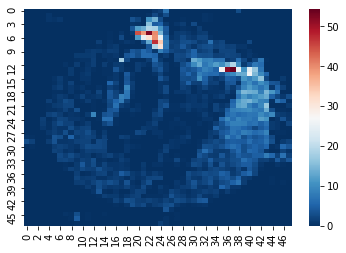

In [13]:
pattern = pd.DataFrame(ori_X.reshape(ori_X.shape[0],48*48))
pattern.index = gene.index

correlated = []
for i in gene.index:
    if i in full_list:
        correlated.append(True)
    else:
        correlated.append(False)
pattern = pattern[correlated].values

##plot aggregated pattern
sns.heatmap(np.sum(pattern,0).reshape(48,48),cmap="RdBu_r")